In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import itertools
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
df = pd.read_csv("Dataset_Linkedin_final.csv")

In [12]:


# Count the number of posts per challenge category
category_counts = df["Challenge category"].value_counts()

# Convert to percentages
category_percentages = df["Challenge category"].value_counts(normalize=True) * 100

# Combine into a single DataFrame
result = pd.DataFrame({
    "Count": category_counts,
    "Percentage": category_percentages.round(2)
})

print(result)


                                 Count  Percentage
Challenge category                                
Data Quality & Bias                 25       31.25
Organizational Resistance           19       23.75
Privacy Security & Compliance       10       12.50
Unclear ROI & Business Case          9       11.25
ai talent shortage                   8       10.00
High Costs & Resource Intensity      3        3.75
Insufficient Data                    3        3.75
Integration with Legacy Systems      3        3.75


/tmp/ipython-input-1071571593.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


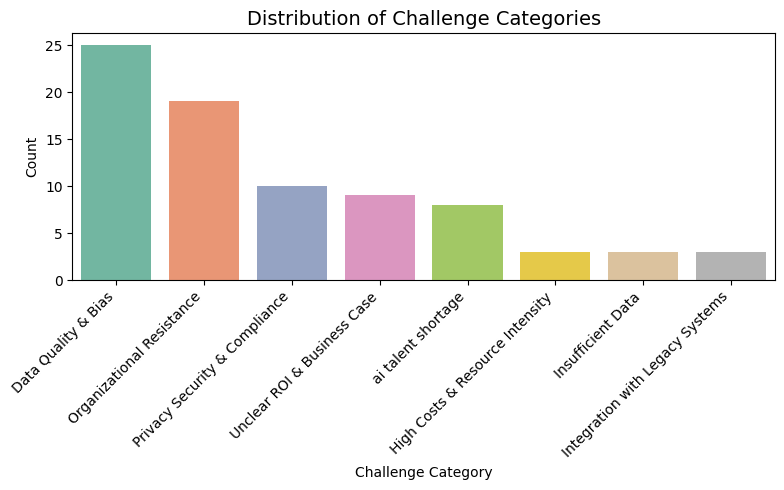

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------
# 1. Challenge Category Distribution (Color-coded)
# ------------------------
plt.figure(figsize=(8,5))
sns.countplot(
    data=df,
    x="Challenge category",
    order=df["Challenge category"].value_counts().index,
    palette="Set2"   # You can try: "viridis", "Set1", "coolwarm", "tab10"
)
plt.title("Distribution of Challenge Categories", fontsize=14)
plt.xlabel("Challenge Category")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Example: mapping raw author roles to broader categories
role_mapping = {
    # Founders / Execs
    "cofounder": "Founder/Executive",
    "co-founder": "Founder/Executive",
    "Founder": "Founder/Executive",
    "CEO/Co-founder": "Founder/Executive",
    "CEO": "Founder/Executive",
    "chief economist": "Founder/Executive",
    "Chief consulting officer": "Founder/Executive",
    "Chief product officer/head": "Founder/Executive",
    "vice president": "Founder/Executive",
    "VP product and marketing": "Founder/Executive",
    "Director": "Founder/Executive",
    "head of clinical informatics": "Founder/Executive",
    "Head of retail investments": "Founder/Executive",
    "product and program management leader": "Founder/Executive",

    # Engineers / Technical
    "Artificial Intelliigence Engineer": "Engineer/Technical",
    "Artificial intelligence consultant": "Engineer/Technical",
    "Principal Software engineer": "Engineer/Technical",
    "systems engineer": "Engineer/Technical",
    "Web developer": "Engineer/Technical",
    "Growth Engineer": "Engineer/Technical",
    "Product manager": "Engineer/Technical",

    # Academics / Experts
    "senior lecturer law": "Academic/Expert",
    "keynote speaker": "Academic/Expert",
    "Senior Technical Writer": "Academic/Expert",

    # Business / Consulting
    "Business engineer": "Business/Consulting",
    "Senior Business development leader": "Business/Consulting",
    "senior client account executive": "Business/Consulting",
    "Tax and consulting managing partner": "Business/Consulting",

    # HR / People
    "Talent acquisition specialist": "HR/People",
    "L&D leader": "HR/People",

    # Legal
    "General counsel": "Legal",

    # Fallback
    "-": "Other"
}


In [15]:
# Assuming df["Author Role"] contains the raw role column
df["Role Group"] = df["Author Role"].map(role_mapping).fillna("Other")


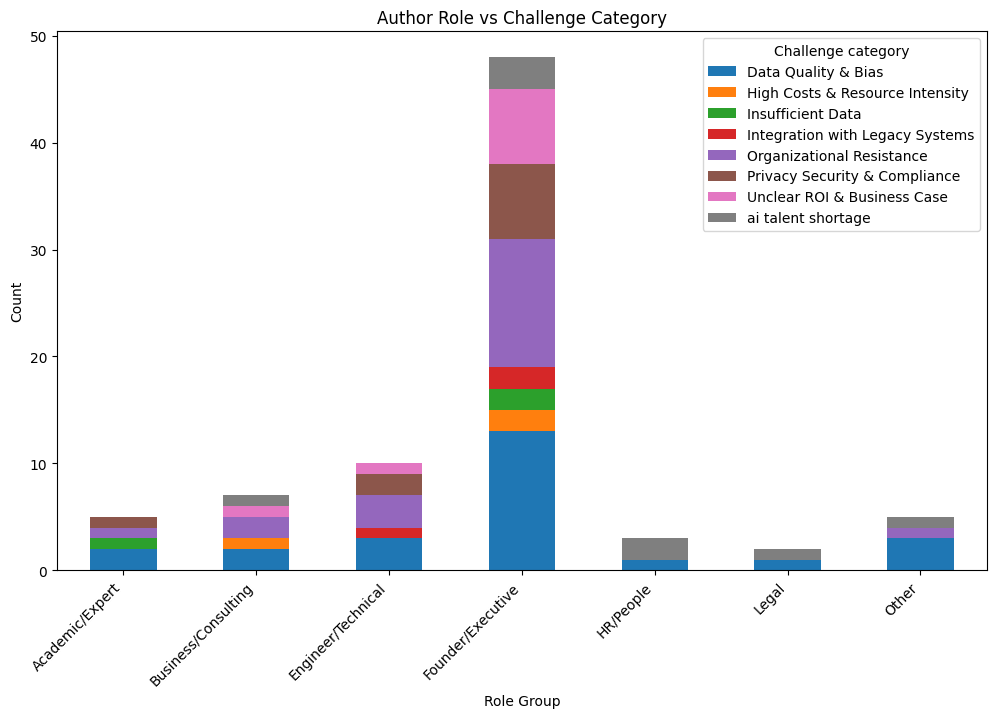

In [16]:
# Cross-tab between grouped roles and challenge category
role_challenge = pd.crosstab(df["Role Group"], df["Challenge category"])

# Plot
role_challenge.plot(kind="bar", stacked=True, figsize=(12,7))
plt.title("Author Role vs Challenge Category")
plt.ylabel("Count")
plt.xlabel("Role Group")
plt.xticks(rotation=45, ha="right")
plt.show()


Total posts: 51
Posts with >=1 label: 51
Posts with >=2 labels (multi-label): 22

Category counts (number of posts that mention category):
                          category  post_count
0              Data Quality & Bias          25
1        Organizational Resistance          19
2    Privacy Security & Compliance          10
3      Unclear ROI & Business Case           9
4               ai talent shortage           8
5  Integration with Legacy Systems           3
6  High Costs & Resource Intensity           3
7                Insufficient Data           3

Top co-occurring pairs:
                               cat1                             cat2  count  \
0         Organizational Resistance    Privacy Security & Compliance      6   
1               Data Quality & Bias               ai talent shortage      6   
2               Data Quality & Bias        Organizational Resistance      5   
3               Data Quality & Bias    Privacy Security & Compliance      4   
4         Organiza

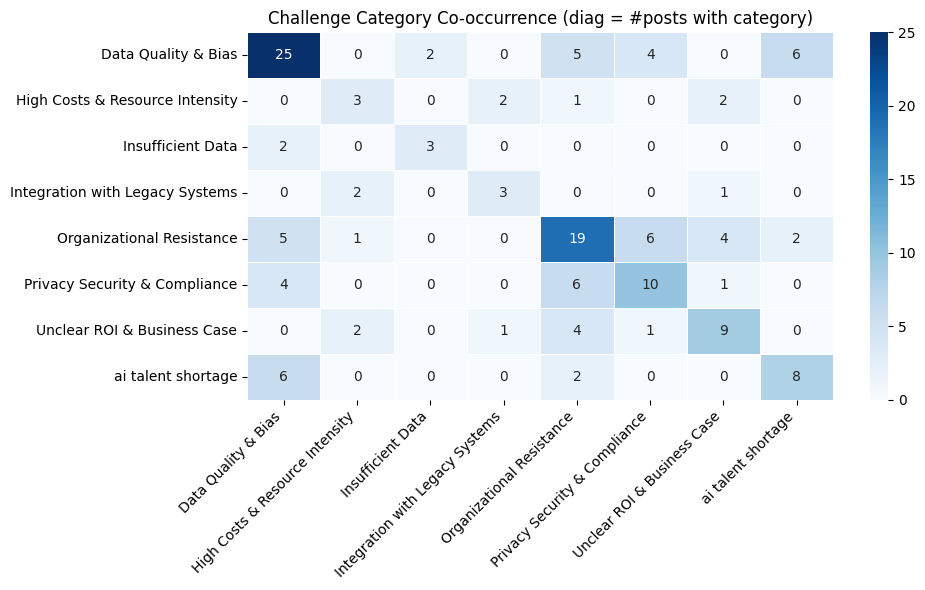

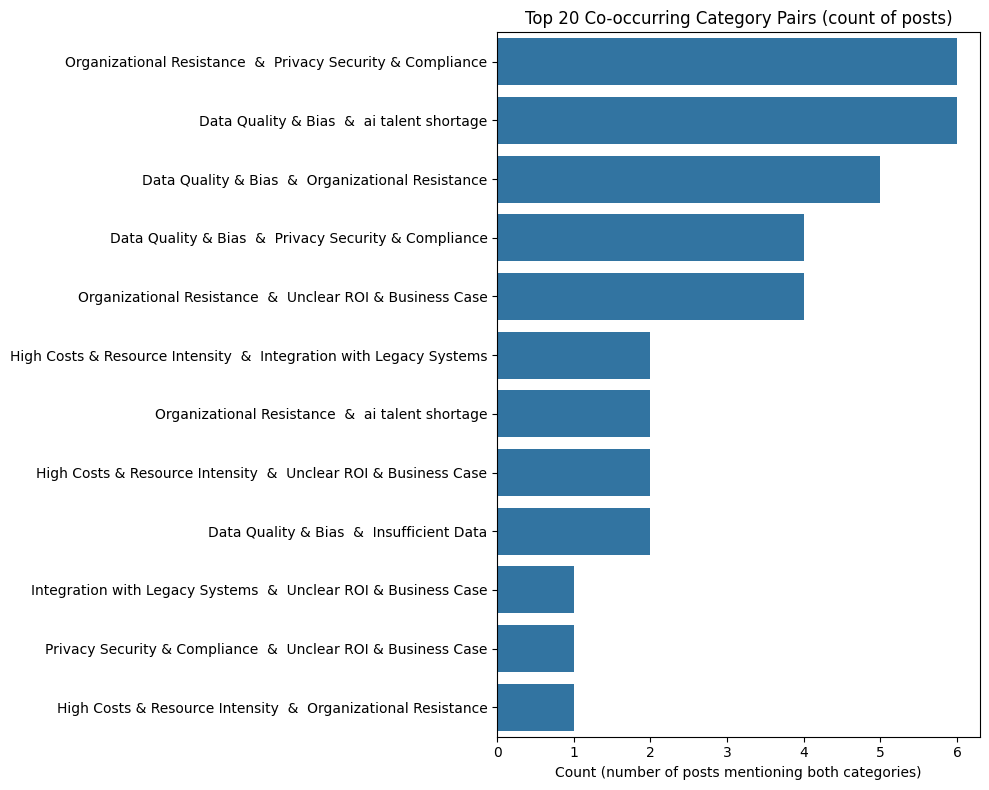


Triplets with support >= 2:
Counter({('Data Quality & Bias', 'Organizational Resistance', 'Privacy Security & Compliance'): 2, ('Data Quality & Bias', 'Organizational Resistance', 'ai talent shortage'): 2})


In [17]:

# ------------- create a stable post identifier -------------
# prefer 'link' (unique), otherwise use the post text
df['link'] = df.get('link', pd.Series(['']*len(df)))  # ensure column exists
df['Post'] = df.get('Post', pd.Series(['']*len(df)))

df['post_id'] = df['link'].astype(str).str.strip()
# if link empty, fallback to post text (strip and shorten to avoid super-long keys)
mask = df['post_id'] == ''
df.loc[mask, 'post_id'] = df.loc[mask, 'Post'].astype(str).str.strip()

# ------------- helper: split & clean labels -------------
def split_labels(cell):
    """
    Split a label cell into a list of labels.
    Handles commas, semicolons, pipes, slashes and newlines.
    """
    if pd.isna(cell):
        return []
    # split on common separators
    parts = re.split(r'[,\n;/|]+', str(cell))
    parts = [p.strip() for p in parts if p.strip()]
    return parts

# apply to each row
df['labels_list'] = df['Challenge category'].apply(split_labels)

# OPTIONAL: canonicalize label names if you have synonyms (populate mapping)
# e.g. mapping = {'Org Resistance':'Organizational Resistance', 'org resist':'Organizational Resistance'}
# mapping = {...}
# def canonicalize(lst, mapping):
#     return [mapping.get(x, x) for x in lst]
# df['labels_list'] = df['labels_list'].apply(lambda L: canonicalize(L, mapping))

# ------------- aggregate labels per post (union) -------------
agg = df.groupby('post_id')['labels_list'].apply(
    lambda lists: sorted(set(itertools.chain.from_iterable(lists)))
)
# agg is a Series indexed by post_id, value = sorted list of unique labels for that post

# some quick stats
total_posts = len(agg)
posts_with_labels = (agg.apply(len) >= 1).sum()
multi_label_posts = (agg.apply(len) >= 2).sum()
print(f"Total posts: {total_posts}")
print(f"Posts with >=1 label: {posts_with_labels}")
print(f"Posts with >=2 labels (multi-label): {multi_label_posts}")

# ------------- category counts (per post) -------------
cat_counter = Counter()
for labels in agg:
    for c in set(labels):
        cat_counter[c] += 1

cat_counts = pd.DataFrame.from_dict(cat_counter, orient='index', columns=['post_count']).sort_values('post_count', ascending=False)
cat_counts.index.name = 'category'
cat_counts = cat_counts.reset_index()
print("\nCategory counts (number of posts that mention category):")
print(cat_counts.head(20))

# ------------- pair co-occurrence counts -------------
pair_counts = Counter()
for labels in agg:
    uniq = sorted(set(labels))
    if len(uniq) >= 2:
        for a, b in itertools.combinations(uniq, 2):
            pair_counts[(a, b)] += 1

pair_df = pd.DataFrame(
    [(a, b, cnt) for (a, b), cnt in pair_counts.items()],
    columns=['cat1', 'cat2', 'count']
).sort_values('count', ascending=False).reset_index(drop=True)

# support percentages
pair_df['support_pct_of_multi_label_posts'] = pair_df['count'] / max(multi_label_posts, 1) * 100
pair_df['support_pct_of_all_posts'] = pair_df['count'] / total_posts * 100

# Jaccard index for each pair = count / (count(cat1) + count(cat2) - count)
cat_count_map = dict(cat_counter)
pair_df['jaccard'] = pair_df.apply(
    lambda r: r['count'] / (cat_count_map.get(r['cat1'], 0) + cat_count_map.get(r['cat2'], 0) - r['count'])
    if (cat_count_map.get(r['cat1'],0) + cat_count_map.get(r['cat2'],0) - r['count'])>0 else 0,
    axis=1
)

print("\nTop co-occurring pairs:")
print(pair_df.head(20))

# Save pair results for your paper
pair_df.to_csv("cooccurring_pairs.csv", index=False)
cat_counts.to_csv("category_post_counts.csv", index=False)

# ------------- build full co-occurrence matrix (with diagonal=category post counts) -------------
all_cats = sorted(cat_counter.keys())
co_matrix = pd.DataFrame(0, index=all_cats, columns=all_cats, dtype=int)

# fill off-diagonals
for (a, b), cnt in pair_counts.items():
    co_matrix.loc[a, b] = cnt
    co_matrix.loc[b, a] = cnt

# fill diagonal with #posts containing the category (use cat_counter)
for c in all_cats:
    co_matrix.loc[c, c] = cat_counter.get(c, 0)

# ------------- Heatmap (raw counts) -------------
plt.figure(figsize=(10, max(6, 0.5 * len(all_cats))))
sns.heatmap(co_matrix, annot=True, fmt="d", cmap="Blues", linewidths=.5)
plt.title("Challenge Category Co-occurrence (diag = #posts with category)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ------------- Top pairs bar chart -------------
top_n = 20
top_pairs = pair_df.head(top_n).copy()
top_pairs['pair_label'] = top_pairs['cat1'] + "  &  " + top_pairs['cat2']

plt.figure(figsize=(10, max(4, 0.4 * top_n)))
sns.barplot(data=top_pairs, x='count', y='pair_label')
plt.title(f"Top {top_n} Co-occurring Category Pairs (count of posts)")
plt.xlabel("Count (number of posts mentioning both categories)")
plt.ylabel("")
plt.tight_layout()
plt.show()

# ------------- helper: frequent sets of size k (pairs/triplets) -------------
def frequent_sets(agg_series, k=2, min_support=1):
    """
    Returns Counter of k-sized sets (tuples sorted) that appear in >= min_support posts.
    - agg_series: Series of lists (unique labels per post)
    - k: size of combinations (2 = pairs, 3 = triplets)
    - min_support: minimum number of posts the set must appear in
    """
    cnt = Counter()
    for labels in agg_series:
        uniq = sorted(set(labels))
        if len(uniq) >= k:
            for comb in itertools.combinations(uniq, k):
                cnt[comb] += 1
    # filter by min support
    return Counter({kset: v for kset, v in cnt.items() if v >= min_support})

# Example: find all triplets that appear >= 2 times
triplets_2plus = frequent_sets(agg, k=3, min_support=2)
print("\nTriplets with support >= 2:")
print(triplets_2plus)

# Save aggregated labels per post if you want to inspect
agg_df = agg.reset_index().rename(columns={'index':'post_id','labels_list':'labels_per_post'})
agg_df.to_csv("labels_aggregated_by_post.csv", index=False)


/tmp/ipython-input-3799465403.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


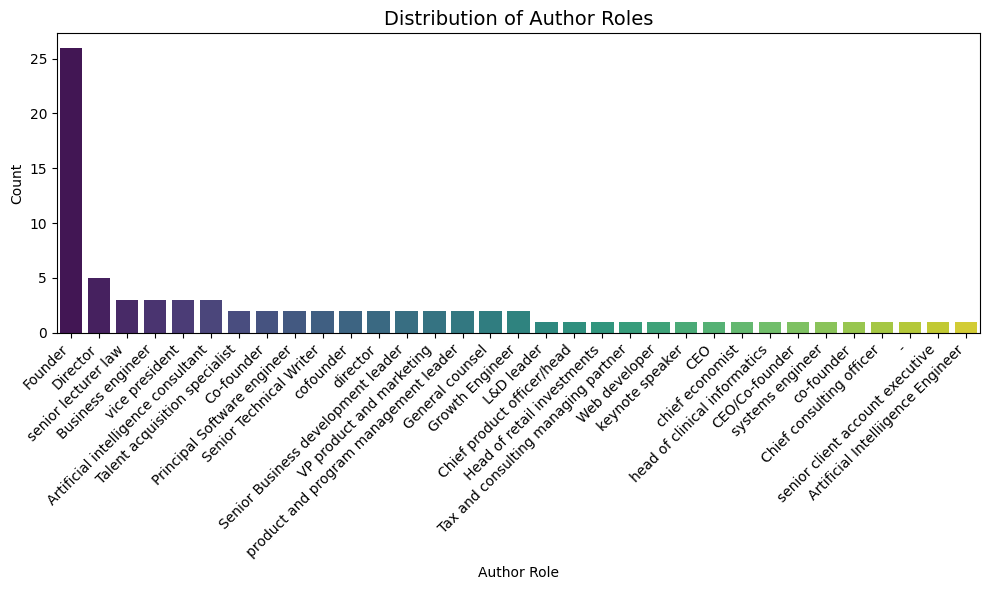

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------
# 2. Author Role Frequency
# ------------------------

plt.figure(figsize=(10,6))
sns.countplot(
    data=df,
    x="Author Role",
    order=df["Author Role"].value_counts().index,   # sorts bars by frequency
    palette="viridis"                               # optional: nice color palette
)
plt.title("Distribution of Author Roles", fontsize=14)
plt.xlabel("Author Role")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")  # rotate labels for readability
plt.tight_layout()
plt.show()
